In [5]:
import numpy as np
from scipy import sparse
import networkx as nx
from scipy.linalg import pinv
from sklearn.linear_model import Lasso
from scipy.spatial.distance import pdist, squareform

# Data Generation Functions
def network_generate(n, eta):
    G = nx.scale_free_graph(n)
    G.remove_edges_from(nx.selfloop_edges(G))
    edges_to_remove = []
    seen = set()
    for edge in G.edges:
        if (edge[0], edge[1]) in seen:
            edges_to_remove.append(edge)
        else:
            seen.add((edge[0], edge[1]))
    G.remove_edges_from(edges_to_remove)
    for edge in G.edges(data=True):
        edge[2]["weight"] = np.random.uniform(1.0 - eta, 1.0 + eta)
    A = nx.adjacency_matrix(G).todense().T
    k_in = np.zeros(n)
    for node in range(n):
        if G.in_degree(node) > 0:
            k_in[node] = sum(data["weight"] for _, _, data in G.in_edges(node, data=True))
    L = np.diag(k_in) - A
    delta = np.max(k_in)
    return G, A, L, delta, k_in

def data_generate(n, m, transient, time, beta, mu, sigma, C, L, delta, gamma):
    def rulkov_map(x):
        x = x.reshape(n, m).T
        return np.asarray([
            beta / (1 + x[0]**2) + x[1],
            x[1] - mu * x[0] - sigma
        ]).T.flatten()
    h = np.eye(m)
    h[1, 1] = 0  # Only couple u-component
    def net_dynamics(x):
        noise = gamma * np.random.uniform(-1, 1, n * m)
        return rulkov_map(x) - (C / delta) * sparse.kron(L, h).dot(x) + noise
    x0 = np.random.uniform(0.0, 1.0, n * m)
    for _ in range(transient):
        x0 = rulkov_map(x0)
    for _ in range(transient):
        x0 = net_dynamics(x0)
    x = np.zeros((n * m, time))
    x[:, 0] = x0
    for t in range(time - 1):
        x[:, t + 1] = net_dynamics(x[:, t])
    return x.reshape(n, m, time)

# HAN-RC Reconstructor Class
class HANRCReconstructor:
    def __init__(self, n_reservoir=200, spectral_radius=0.95, lasso_alpha=1e-4):
        self.N_res = n_reservoir
        self.rho = spectral_radius
        self.alpha = lasso_alpha
    
    def train_node_reservoir(self, x_node):
        """Train small ESN on single node's m-dim time series, return flattened W_out as features."""
        m, T = x_node.shape
        # Create reservoir
        W_res = np.random.randn(self.N_res, self.N_res) * 0.1
        eigenvalues = np.linalg.eigvals(W_res)
        max_eig = np.max(np.abs(eigenvalues))
        if max_eig > 0:
            W_res *= self.rho / max_eig
        W_in = np.random.randn(self.N_res, m)
        # Collect states
        R = np.zeros((self.N_res, T))
        r = np.zeros(self.N_res)
        for t in range(T):
            r = np.tanh(W_res @ r + W_in @ x_node[:, t])
            R[:, t] = r
        # Train readout (ridge for stability)
        R_train = R[:, :-1]
        Y_train = x_node[:, 1:]
        ridge_param = 1e-6
        W_out = Y_train @ R_train.T @ pinv(R_train @ R_train.T + ridge_param * np.eye(self.N_res))
        return W_out.flatten()  # Feature vector
    
    def detect_hub(self, X):
        """Detect hub via feature distances."""
        n = X.shape[0]
        node_features = []
        for i in range(n):
            features = self.train_node_reservoir(X[i])
            node_features.append(features)
        # Distance matrix
        dist_matrix = squareform(pdist(node_features, 'euclidean'))
        # Hub: max row-sum (most distinct)
        node_scores = np.sum(dist_matrix, axis=1)
        hub_id = np.argmax(node_scores)
        # Pick a low-degree node (min row-sum after hub)
        low_degree_ids = np.argsort(node_scores)[1:]  # Exclude hub
        ld_id = low_degree_ids[0]  # Simplest low-degree choice
        return hub_id, ld_id, dist_matrix
    
    def infer_couplings(self, X, hub_id):
        """Lasso on other u's to predict hub du/dt."""
        n, m, T = X.shape
        u_series = X[:, 0, :]  # u-components
        du_hub = u_series[hub_id, 1:] - u_series[hub_id, :-1]  # Discrete derivative
        # Input library: other nodes' u (exclude hub)
        mask = np.ones(n, dtype=bool)
        mask[hub_id] = False
        inputs = u_series[mask, :-1].T  # (T-1, n-1)
        # Lasso for sparsity
        lasso = Lasso(alpha=self.alpha)
        lasso.fit(inputs, du_hub)
        couplings = np.abs(lasso.coef_)  # Incoming strengths to hub
        # Insert 0 for self
        full_couplings = np.zeros(n)
        full_couplings[mask] = couplings
        return full_couplings
    
    def reconstruct_laplacian(self, X):
        """Main reconstruction."""
        n, m, T = X.shape
        hub_id, ld_id, dist_matrix = self.detect_hub(X)
        coupling_strengths = self.infer_couplings(X, hub_id)
        # Build L: weight by inverse dist for refinement
        L_pred = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                if i != j:
                    weight = coupling_strengths[j] * (1.0 / (1.0 + dist_matrix[i, j]))
                    if weight > 0.0001:  # Adjusted threshold for epsilon
                        L_pred[i, j] = -weight  # Off-diag negative for Laplacian
        np.fill_diagonal(L_pred, -np.sum(L_pred, axis=1))  # Diag = -row sums
        return L_pred, hub_id, ld_id

# Performance Metrics
def compute_performance_metrics(L_true, L_pred, epsilon=0.0001):
    n = L_true.shape[0]
    L_true_off = L_true - np.diag(np.diag(L_true))
    L_pred_off = L_pred - np.diag(np.diag(L_pred))
    positives_mask = np.abs(L_true_off) > epsilon
    negatives_mask = np.abs(L_true_off) <= epsilon
    fn = np.sum(positives_mask & (np.abs(L_pred_off) <= epsilon))
    fp = np.sum(negatives_mask & (np.abs(L_pred_off) > epsilon))
    positives = np.sum(positives_mask)
    negatives = n**2 - n - positives
    fnr = fn / positives if positives > 0 else 0.0
    fpr = fp / negatives if negatives > 0 else 0.0
    return fnr, fpr

In [53]:
# Parameters
n = 20
m = 2
time = 500
transient = 14000
beta = 4.1
mu = 0.001
sigma = 0.001
C = 0.1
gamma = 0.001
eta = 0.2

# Adjustable Parameters
epsilon = 0.0001  # Threshold for edge detection
n_reservoir=200
spectral_radius=0.95
lasso_alpha = 1e-4  # Lasso regularization parameter

# Generate Data
G, A, L, delta, k_in = network_generate(n, eta)
x = data_generate(n, m, transient, time, beta, mu, sigma, C, L, delta, gamma)
print(f"Data generated: {n} nodes, {m} dims, {time} steps")

# Reconstruct Network
recon = HANRCReconstructor(n_reservoir=n_reservoir, spectral_radius=spectral_radius, lasso_alpha=lasso_alpha)
L_pred, hub_id, ld_id = recon.reconstruct_laplacian(x)

# Compute Performance Metrics
fnr, fpr = compute_performance_metrics(L, L_pred, epsilon=epsilon)

# Additional Metrics (for completeness)
edge_count = np.sum(np.abs(L_pred - np.diag(np.diag(L_pred))) > 0.0001)

# Print Results
print(f"Hub ID: {hub_id}, Low-Degree ID: {ld_id}")
print(f"Reconstructed Graph has {edge_count} edges")
print(f"False Negative Rate (FNR): {fnr:.4f}")
print(f"False Positive Rate (FPR): {fpr:.4f}")
print(f"FNR/FPR: {fnr/fpr:.4f}")

Data generated: 20 nodes, 2 dims, 500 steps
Hub ID: 1, Low-Degree ID: 16
Reconstructed Graph has 342 edges
False Negative Rate (FNR): 0.0435
False Positive Rate (FPR): 0.8964
FNR/FPR: 0.0485


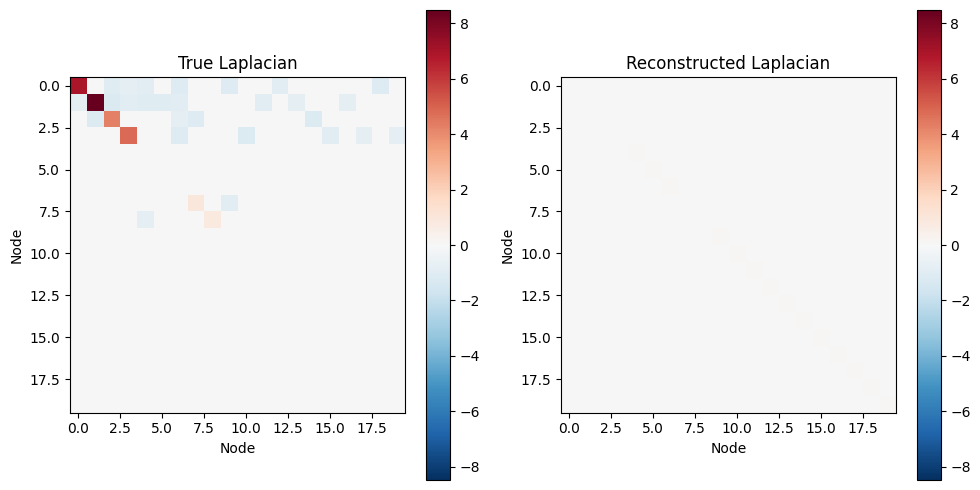

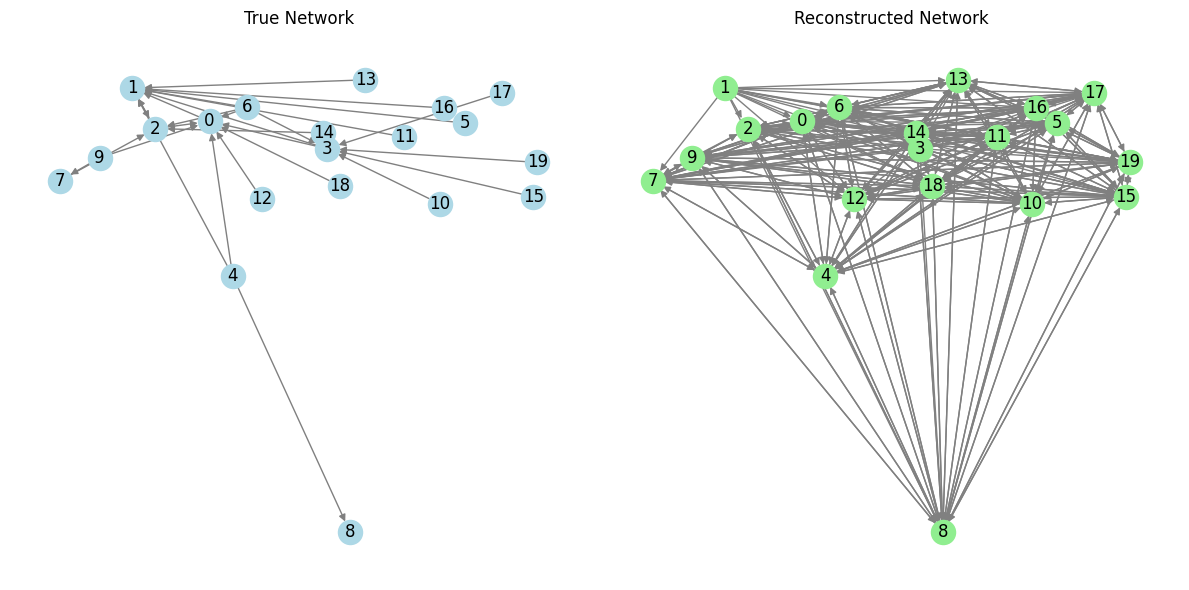

Frobenius Error: 13.7121
Jaccard Edge Overlap: 0.0621


In [49]:
# Additional Comparison Functions
import matplotlib.pyplot as plt  # Ensure this is imported at the top if not already

def plot_laplacian_heatmaps(L_true, L_pred):
    """Plot side-by-side heatmaps of true and reconstructed Laplacians."""
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    vmax = max(np.abs(L_true).max(), np.abs(L_pred).max())
    
    im1 = axes[0].imshow(L_true, cmap='RdBu_r', vmin=-vmax, vmax=vmax)
    axes[0].set_title('True Laplacian')
    axes[0].set_xlabel('Node')
    axes[0].set_ylabel('Node')
    plt.colorbar(im1, ax=axes[0])
    
    im2 = axes[1].imshow(L_pred, cmap='RdBu_r', vmin=-vmax, vmax=vmax)
    axes[1].set_title('Reconstructed Laplacian')
    axes[1].set_xlabel('Node')
    axes[1].set_ylabel('Node')
    plt.colorbar(im2, ax=axes[1])
    
    plt.tight_layout()
    plt.show()  # Or plt.savefig('laplacian_comparison.png') to save

def plot_network_graphs(G_true, L_pred):
    """Plot side-by-side directed graphs of true and reconstructed networks."""
    # Reconstruct adjacency from L_pred (adj = diag(L) - L, threshold small values)
    adj_pred = np.diag(np.diag(L_pred)) - L_pred
    adj_pred[np.abs(adj_pred) < 0.0001] = 0  # Threshold for edges
    G_pred = nx.from_numpy_array(adj_pred, create_using=nx.DiGraph)
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    pos = nx.spring_layout(G_true)  # Use same layout for comparison
    
    nx.draw(G_true, pos, with_labels=True, node_color='lightblue', 
            edge_color='gray', arrows=True, ax=axes[0])
    axes[0].set_title('True Network')
    
    nx.draw(G_pred, pos, with_labels=True, node_color='lightgreen', 
            edge_color='gray', arrows=True, ax=axes[1])
    axes[1].set_title('Reconstructed Network')
    
    plt.tight_layout()
    plt.show()  # Or plt.savefig('network_graph_comparison.png') to save

def additional_metrics(L_true, L_pred):
    """Compute additional comparison metrics."""
    # Frobenius norm error
    fro_error = np.linalg.norm(L_true - L_pred, 'fro')
    print(f"Frobenius Error: {fro_error:.4f}")
    
    # Edge overlap (Jaccard similarity)
    true_edges = set((i, j) for i in range(L_true.shape[0]) 
                     for j in range(L_true.shape[1]) if i != j and abs(L_true[i, j]) > 0.0001)
    pred_edges = set((i, j) for i in range(L_pred.shape[0]) 
                     for j in range(L_pred.shape[1]) if i != j and abs(L_pred[i, j]) > 0.0001)
    intersection = len(true_edges & pred_edges)
    union = len(true_edges | pred_edges)
    jaccard = intersection / union if union > 0 else 0
    print(f"Jaccard Edge Overlap: {jaccard:.4f}")

# After print statements for FNR/FPR
plot_laplacian_heatmaps(L, L_pred)
plot_network_graphs(G, L_pred)
additional_metrics(L, L_pred)